In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import ParameterGrid
import pysindy as ps
import os
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from torch.fft import fft, ifft
from mpl_toolkits.mplot3d import Axes3D
import optuna
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import MultiTaskLassoCV, LinearRegression
from sklearn.feature_selection import SelectFromModel
from typing import Tuple, Any, Iterable, Dict
from sklearn.model_selection import train_test_split
from scipy.integrate import solve_ivp


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:
#for Lorenz Data2
train_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data2\train_lorenz_subset.npy"
test_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data2\test_lorenz_subset.npy"
val_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data2\validate_lorenz_subset.npy"
train_data = np.load(train_file_path)
test_data = np.load(test_file_path)
val_data = np.load(val_file_path)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)

Train data shape: (700, 100, 3)
Test data shape: (150, 100, 3)
Validation data shape: (150, 100, 3)


In [ ]:
#for Lorenz Data1
train_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data1\lorenz_train.npy"
test_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data1\lorenz_test.npy"
val_file_path = r"C:\Users\User\Documents\GitHub\PIML\Lorenz Attractor\Data Lorenz Attractor\Lorenz Data1\lorenz_val.npy"
train_data = np.load(train_file_path)
test_data = np.load(test_file_path)
val_data = np.load(val_file_path)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", val_data.shape)


Examples from the test_data:
[[-15.0196116   -8.5755115  -15.80434264]
 [  5.40731734  21.8182917   37.99159639]
 [  2.0887699   -1.96373529  28.97019439]
 [ -2.00440493  -3.31525159  15.09568479]
 [-11.82576873 -18.48058119  21.95948944]
 [ -4.11355315   1.79373936  29.87806065]
 [  1.1585508    2.03657182  15.15507363]
 [  8.11315048  14.3947543   14.02856291]
 [  7.90271041  -1.39684331  35.55261621]
 [ -1.92670169  -3.29167728  17.8452223 ]
 [-10.18743464 -16.19641537  19.82190437]
 [ -6.13096653   0.38042586  31.81521768]
 [ -0.4954999   -0.45642708  16.07733342]
 [ -2.38388607  -4.4818081    8.73367888]
 [-16.72510326 -19.96505404  35.27392857]
 [  0.84161686   4.37056578  25.2888914 ]
 [  7.33858569  11.19964977  18.90264182]
 [ 10.40598119   5.32682899  34.63432627]
 [  3.21350557   3.51076088  20.12811934]
 [ 10.21518153  15.24809448  21.73319133]
 [  6.65751136   1.23130109  31.24808436]
 [  2.60328476   3.61777176  16.85596532]
 [ 11.79481201  17.59416325  23.36604516]
 [  

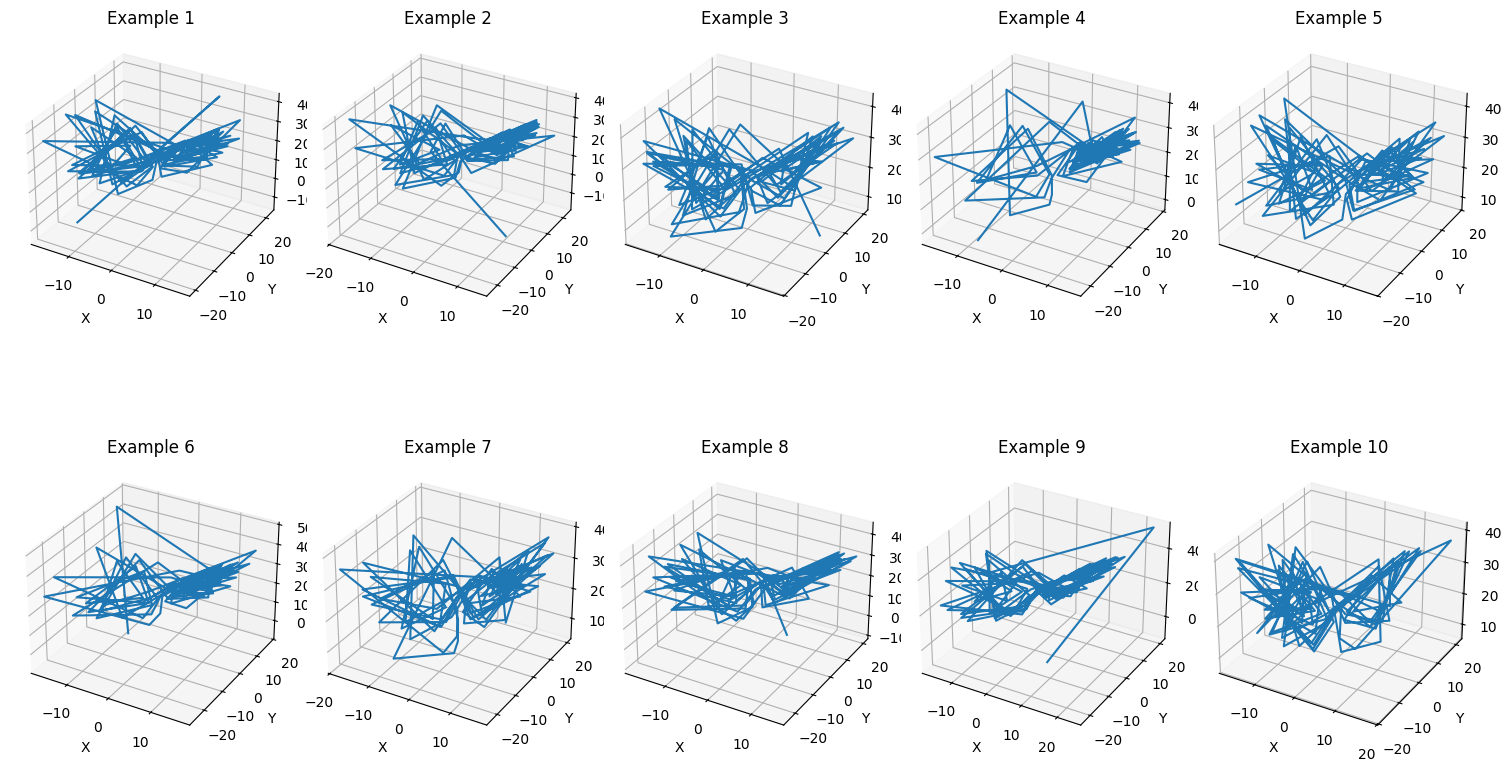

In [14]:
print("\nExamples from the test_data:")
fig = plt.figure(figsize=(15, 10))
for i in range(10):
    example = test_data[i]
    print(example)
    ax = fig.add_subplot(2, 5, i + 1, projection='3d')
    ax.plot(example[:, 0], example[:, 1], example[:, 2])
    ax.set_title(f"Example {i + 1}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.tight_layout()
plt.show()

In [6]:
batch_size = 64

def prepare_dataloader(data, batch_size):
    inputs = torch.tensor(data[:, :-1, :], dtype=torch.float32)  # All but last timestep as input
    targets = torch.tensor(data[:, -1, :], dtype=torch.float32)  # Last timestep as target
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = prepare_dataloader(train_data, batch_size)
val_loader = prepare_dataloader(val_data, batch_size)
test_loader = prepare_dataloader(test_data, batch_size)

In [7]:
class AdvancedConvFNO(nn.Module):
    def __init__(self, modes, width, conv_filters):
        super(AdvancedConvFNO, self).__init__()
        self.modes = modes
        self.width = width

        # Convolutional Layers
        self.conv1 = nn.Conv1d(3, conv_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_filters, conv_filters, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(conv_filters, self.width, kernel_size=3, padding=1)

        # Fourier Neural Operator
        self.fc0 = nn.Linear(self.width, self.width)
        self.fc1 = nn.Linear(self.width, self.width)
        self.fc2 = nn.Linear(self.width, 3)  # Output (x, y, z)

    def forward(self, x):
        batchsize, seq_len, channels = x.shape

        # Apply convolutions
        x = x.permute(0, 2, 1)  # Change to (batch, channels, seq_len)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.permute(0, 2, 1)  # Back to (batch, seq_len, channels)

        # Fourier Neural Operator
        x = self.fc0(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x[:, -1, :])  # Use the last timestep
        return x

In [8]:
# Define SINDy for Post-Training Analysis
def apply_sindy(train_data_flat, test_data_flat, dt):
    x_train = train_data_flat[:-1]
    dx_train = (train_data_flat[1:] - train_data_flat[:-1]) / dt
    x_test = test_data_flat[:-1]
    dx_test = (test_data_flat[1:] - test_data_flat[:-1]) / dt

    # Define the SINDy model
    feature_library = ps.PolynomialLibrary(degree=3)
    optimizer = ps.STLSQ(threshold=0.1)
    sindy_model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)

    # Fit and evaluate
    sindy_model.fit(x_train, t=dt, x_dot=dx_train)
    print("\nSINDy Discovered Equations:")
    sindy_model.print()
    print(f"SINDy Test Score: {sindy_model.score(x_test, t=dt, x_dot=dx_test):.4f}")

# Accuracy Calculation
def calculate_accuracy(outputs, targets, tolerance=0.1):
    correct = torch.sum(torch.abs(outputs - targets) < tolerance).item()
    total = targets.numel()
    return correct / total * 100


In [9]:
# Training Loop with Accuracy
def train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += torch.sum(torch.abs(outputs - targets) < 0.1).item()
            train_total += targets.numel()

        train_accuracy = train_correct / train_total * 100

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_correct += torch.sum(torch.abs(outputs - targets) < 0.1).item()
                val_total += targets.numel()

        val_accuracy = val_correct / val_total * 100

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return val_loss / len(val_loader)

In [10]:
# Hyperparameter Grid
param_grid = {
    'modes': [16, 32],
    'width': [64, 128],
    'conv_filters': [16, 32],
    'learning_rate': [0.001, 0.0005],
    'epochs': [50]
}

best_model = None
best_loss = float('inf')
best_params = None

# Grid Search for Hyperparameters
for params in ParameterGrid(param_grid):
    print(f"Testing params: {params}")
    model = AdvancedConvFNO(modes=params['modes'], width=params['width'], conv_filters=params['conv_filters'])
    val_loss = train_and_evaluate(model, train_loader, val_loader,
                                  epochs=params['epochs'],
                                  learning_rate=params['learning_rate'])
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_params = params

print(f"Best Params: {best_params}, Best Validation Loss: {best_loss:.4f}")


Testing params: {'conv_filters': 16, 'epochs': 50, 'learning_rate': 0.001, 'modes': 16, 'width': 64}
Epoch 1/50, Train Loss: 29.1647, Train Accuracy: 5.25%, Val Loss: 2.1320, Val Accuracy: 7.45%
Epoch 2/50, Train Loss: 1.0926, Train Accuracy: 14.59%, Val Loss: 0.1349, Val Accuracy: 26.63%
Epoch 3/50, Train Loss: 0.0845, Train Accuracy: 36.16%, Val Loss: 0.0818, Val Accuracy: 39.60%
Epoch 4/50, Train Loss: 0.0564, Train Accuracy: 42.60%, Val Loss: 0.0527, Val Accuracy: 46.48%
Epoch 5/50, Train Loss: 0.0429, Train Accuracy: 46.94%, Val Loss: 0.0451, Val Accuracy: 45.80%
Epoch 6/50, Train Loss: 0.0358, Train Accuracy: 50.59%, Val Loss: 0.0320, Val Accuracy: 46.25%
Epoch 7/50, Train Loss: 0.0272, Train Accuracy: 54.97%, Val Loss: 0.0221, Val Accuracy: 60.07%
Epoch 8/50, Train Loss: 0.0230, Train Accuracy: 58.86%, Val Loss: 0.0167, Val Accuracy: 68.27%
Epoch 9/50, Train Loss: 0.0236, Train Accuracy: 57.46%, Val Loss: 0.0228, Val Accuracy: 55.85%
Epoch 10/50, Train Loss: 0.0194, Train Accura

In [ ]:
def advanced_sindy(train_data_flat, test_data_flat, dt):
    x_train = train_data_flat[:-1]
    dx_train = (train_data_flat[1:] - train_data_flat[:-1]) / dt
    x_test = test_data_flat[:-1]
    dx_test = (test_data_flat[1:] - test_data_flat[:-1]) / dt

    # Define multiple libraries to test
    polynomial_degrees = [2, 3, 4, 5]  # Include higher polynomial degrees
    thresholds = np.linspace(0.01, 0.2, 10)  # Finer threshold range
    n_frequencies = [3, 5, 7]  # Test different numbers of Fourier frequencies

    best_model = None
    best_score = -float("inf")
    best_params = {}

    for degree in polynomial_degrees:
        for threshold in thresholds:
            for freq in n_frequencies:
                print(f"Testing SINDy with Polynomial Degree: {degree}, Threshold: {threshold}, Frequencies: {freq}")

                # Define the SINDy model
                feature_library = ps.PolynomialLibrary(degree=degree) + ps.FourierLibrary(n_frequencies=freq)
                optimizer = ps.STLSQ(threshold=threshold)
                sindy_model = ps.SINDy(
                    optimizer=optimizer,
                    feature_library=feature_library,
                    differentiation_method=ps.SmoothedFiniteDifference()  # Use smoother differentiation
                )

                # Fit the model
                sindy_model.fit(x_train, t=dt, x_dot=dx_train)
                score = sindy_model.score(x_test, t=dt, x_dot=dx_test)

                if score > best_score:
                    best_model = sindy_model
                    best_score = score
                    best_params = {"degree": degree, "threshold": threshold, "frequencies": freq}

    # Print the best model's equations
    print("\nBest SINDy Model:")
    best_model.print()
    print(f"Best SINDy Test Score: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")

    # Evaluate on the test set
    test_score = best_model.score(x_test, t=dt, x_dot=dx_test)
    print(f"Final SINDy Test Score: {test_score:.4f}")

    return best_model, best_params, test_score

# Apply the updated SINDy
best_sindy_model, best_params, test_score = advanced_sindy(train_data_flat, test_data_flat, dt=0.01)

In [ ]:
def test_and_compare(best_model, best_sindy_model, test_loader, dt):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.to(device)

    best_model.eval()
    all_model_predictions = []
    all_ground_truth = []
    all_sindy_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.cpu().numpy()
            outputs = best_model(inputs).cpu().numpy()
            
            # Collect predictions and ground truth
            all_model_predictions.append(outputs)
            all_ground_truth.append(targets)
            
            # SINDy predictions
            test_inputs_flat = inputs.cpu().numpy().reshape(-1, inputs.shape[-1])
            sindy_predictions = best_sindy_model.predict(test_inputs_flat)
            all_sindy_predictions.append(sindy_predictions[-targets.shape[0]:])  # Use last part of the prediction

    # Convert lists to arrays
    all_model_predictions = np.concatenate(all_model_predictions, axis=0)
    all_ground_truth = np.concatenate(all_ground_truth, axis=0)
    all_sindy_predictions = np.concatenate(all_sindy_predictions, axis=0)

    # Calculate errors
    model_mae = mean_absolute_error(all_ground_truth, all_model_predictions)
    sindy_mae = mean_absolute_error(all_ground_truth, all_sindy_predictions)
    
    print(f"Model Mean Absolute Error: {model_mae:.4f}")
    print(f"SINDy Mean Absolute Error: {sindy_mae:.4f}")

    # Visualize comparisons for a few samples
    num_samples_to_plot = 5
    fig = plt.figure(figsize=(15, 10))
    for i in range(num_samples_to_plot):
        ax = fig.add_subplot(1, num_samples_to_plot, i + 1, projection='3d')

        # Ground truth
        ax.plot(
            all_ground_truth[i, :, 0],
            all_ground_truth[i, :, 1],
            all_ground_truth[i, :, 2],
            'g',
            label="Ground Truth"
        )
        # Model predictions
        ax.plot(
            all_model_predictions[i, :, 0],
            all_model_predictions[i, :, 1],
            all_model_predictions[i, :, 2],
            'b',
            label="Model Predictions"
        )
        # SINDy predictions
        ax.plot(
            all_sindy_predictions[i, :, 0],
            all_sindy_predictions[i, :, 1],
            all_sindy_predictions[i, :, 2],
            'r',
            label="SINDy Predictions"
        )
        ax.set_title(f"Sample {i + 1}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.legend()

    plt.tight_layout()
    plt.show()


# Prepare the dataloader for the test dataset
test_loader = prepare_dataloader(test_data, batch_size)

# Compare the predictions of the best model and SINDy model
test_and_compare(best_model, best_sindy_model, test_loader, dt=0.01)